# Experiment 1 - LLM Strategies

In [8]:
import os
import json
import csv
import sys
import logging
import warnings
import numpy as np
import pandas as pd
warnings.filterwarnings("ignore")


if False:
    %pip install python-dotenv==1.0.1
    %pip install tqdm==4.66.5
    %pip install openai==1.58.1

%load_ext dotenv

FUNDAMENTALS_PATH = os.getenv("FUNDAMENTALS_PATH", '/fundamentals')
LLM_PROMPTS_PATH = os.getenv("LLM_PROMPTS_PATH", '/prompts')
FUNDAMENTALS_PATH = os.getenv("FUNDAMENTALS_PATH", '/fundamentals')
HISTORIC_PATH = os.getenv("HISTORIC_PATH", '/historic')
MACRO_PATH = os.getenv("MACRO_PATH", '/macro')
OPTIONS_PATH = os.getenv("OPTIONS_PATH", '/options')
LLM_OUTPUT_PATH = os.getenv("LLM_OUTPUT_PATH", '/llm_data')
# LLM_OUTPUT_PATH = f"{LLM_OUTPUT_PATH}/fast"
LOGS_PATH = os.getenv("LOGS_PATH", '/logs')
paths = [LLM_OUTPUT_PATH, LOGS_PATH]
for path in paths:
    if path and not os.path.exists(path):
        os.makedirs(path)

if "KAGGLE_KERNEL_RUN_TYPE" in os.environ:
    logging.info("Running in Kaggle...")

    DATA_PATH = "/kaggle/input/thesis/data"
    FUNDAMENTALS_PATH = DATA_PATH + FUNDAMENTALS_PATH
    HISTORIC_PATH = DATA_PATH + HISTORIC_PATH
    MACRO_PATH = DATA_PATH + MACRO_PATH
    OPTIONS_PATH = DATA_PATH + OPTIONS_PATH
    LLM_PROMPTS_PATH = DATA_PATH + LLM_PROMPTS_PATH
    sys.path.insert(1, "/kaggle/usr/lib/thesis_utils")
    sys.path.insert(1, "/kaggle/usr/lib/data_utils")
else:
    DATA_PATH = './data'
    module_path = os.path.abspath(os.path.join(os.getcwd(), 'utils'))
    if module_path not in sys.path:
        sys.path.append(module_path)

from tqdm.notebook import tqdm

from openai import OpenAI
from data_utils import *

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


## Environment and Constants

In [9]:
OPENAI_MODEL = os.getenv("OPENAI_MODEL") # "gpt-4.1-nano" #
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
STARTDATE = '2018-01-01'
ENDDATE = '2020-01-01'

## LLM Setup

In [10]:
OPENAI_CLIENT = OpenAI(api_key=OPENAI_API_KEY)


In [11]:
def load_stock_data(ticker):
    input_file = f"{HISTORIC_PATH}/engineered_{ticker}_data.parquet"

    start_date = pd.to_datetime(STARTDATE, utc=True)
    end_date = pd.to_datetime(ENDDATE, utc=True)

    engineered_df = pd.read_parquet(input_file)
    engineered_df.set_index('Date', inplace=True)
    engineered_df = engineered_df[(engineered_df.index >= start_date) & (engineered_df.index <= end_date)]

    return engineered_df


In [12]:
def run_llm_trade_experiment(ticker_df,
                              ticker,
                              prompt_version,
                              risk_version,
                              prompt_path=LLM_PROMPTS_PATH,
                              output_path=LLM_OUTPUT_PATH,
                              client=OPENAI_CLIENT,
                              model=OPENAI_MODEL,
                              start_date=STARTDATE,
                              end_date=ENDDATE,
                              news_yaml_file=None,
                              plot=True):
    results_dir = f'{output_path}/results/{risk_version}/{prompt_version}/{ticker}'
    figures_dir = f'{output_path}/figures/{risk_version}/{prompt_version}/{ticker}'
    os.makedirs(results_dir, exist_ok=True)
    os.makedirs(figures_dir, exist_ok=True)

    results_file = os.path.join(results_dir, 'llm_results.json')
    data_file = os.path.join(results_dir, 'llm_data.csv')
    fig1_file = f"{figures_dir}/fig1_llm_trade_analysis.png"
    fig2_file = f"{figures_dir}/fig2_llm_trading_signals.png"
    fig3_file = f"{figures_dir}/fig3_llm_distributions.png"
    fig4_file = f"{figures_dir}/fig4_llm_evaluations.png"

    if os.path.exists(results_file) and os.path.exists(data_file) and all(os.path.exists(f) for f in [fig1_file, fig2_file, fig3_file]):
        with open(results_file, 'r') as f:
            llm_trading_metrics = json.load(f)
        llm_trades_df = pd.read_csv(data_file)
    else:
        output_dir = f'{output_path}/response/{risk_version}/{prompt_version}'
        os.makedirs(output_dir, exist_ok=True)

        llm_trades_df = generate_strategy_for_ticker(
                                    ticker_df=ticker_df,
                                    ticker=ticker,
                                    LLM_OUTPUT_PATH=output_dir,
                                    persona=PERSONA,
                                    HIGH_RISK_PROFILE=HIGH_RISK_PROFILE if risk_version == 'r' else LOW_RISK_PROFILE,
                                    HIGH_OBJECTIVES=HIGH_OBJECTIVES if risk_version == 'r' else LOW_OBJECTIVES,
                                    client=client,
                                    model=model,
                                    strategy_yaml_file=f'{prompt_path}/strat_prompt_{prompt_version}.yml',
                                    news_yaml_file=f'{prompt_path}/{news_yaml_file}' if news_yaml_file else None,
                                    start_date=start_date,
                                    end_date=end_date,
                                    max_news=5 if news_yaml_file else 0,
                                    time_horizon='monthly',
                                )
        llm_trading_metrics, llm_trades_df = evaluate_trading_metrics(llm_trades_df)
        with open(results_file, 'w') as f:
            json.dump(llm_trading_metrics, f, indent=4)
        llm_trades_df.to_csv(data_file, index=False, quoting=csv.QUOTE_MINIMAL, escapechar='\\')
        fig1, fig3, fig2 = plot_llm_trade(llm_trades_df, plot=plot)
        fig1.savefig(fig1_file, dpi=300, bbox_inches='tight')
        fig2.savefig(fig2_file, dpi=300, bbox_inches='tight')
        fig3.savefig(fig3_file, dpi=300, bbox_inches='tight')
    return llm_trading_metrics, llm_trades_df

Generating strategies for TSLA:   0%|          | 0/497 [00:00<?, ?it/s]

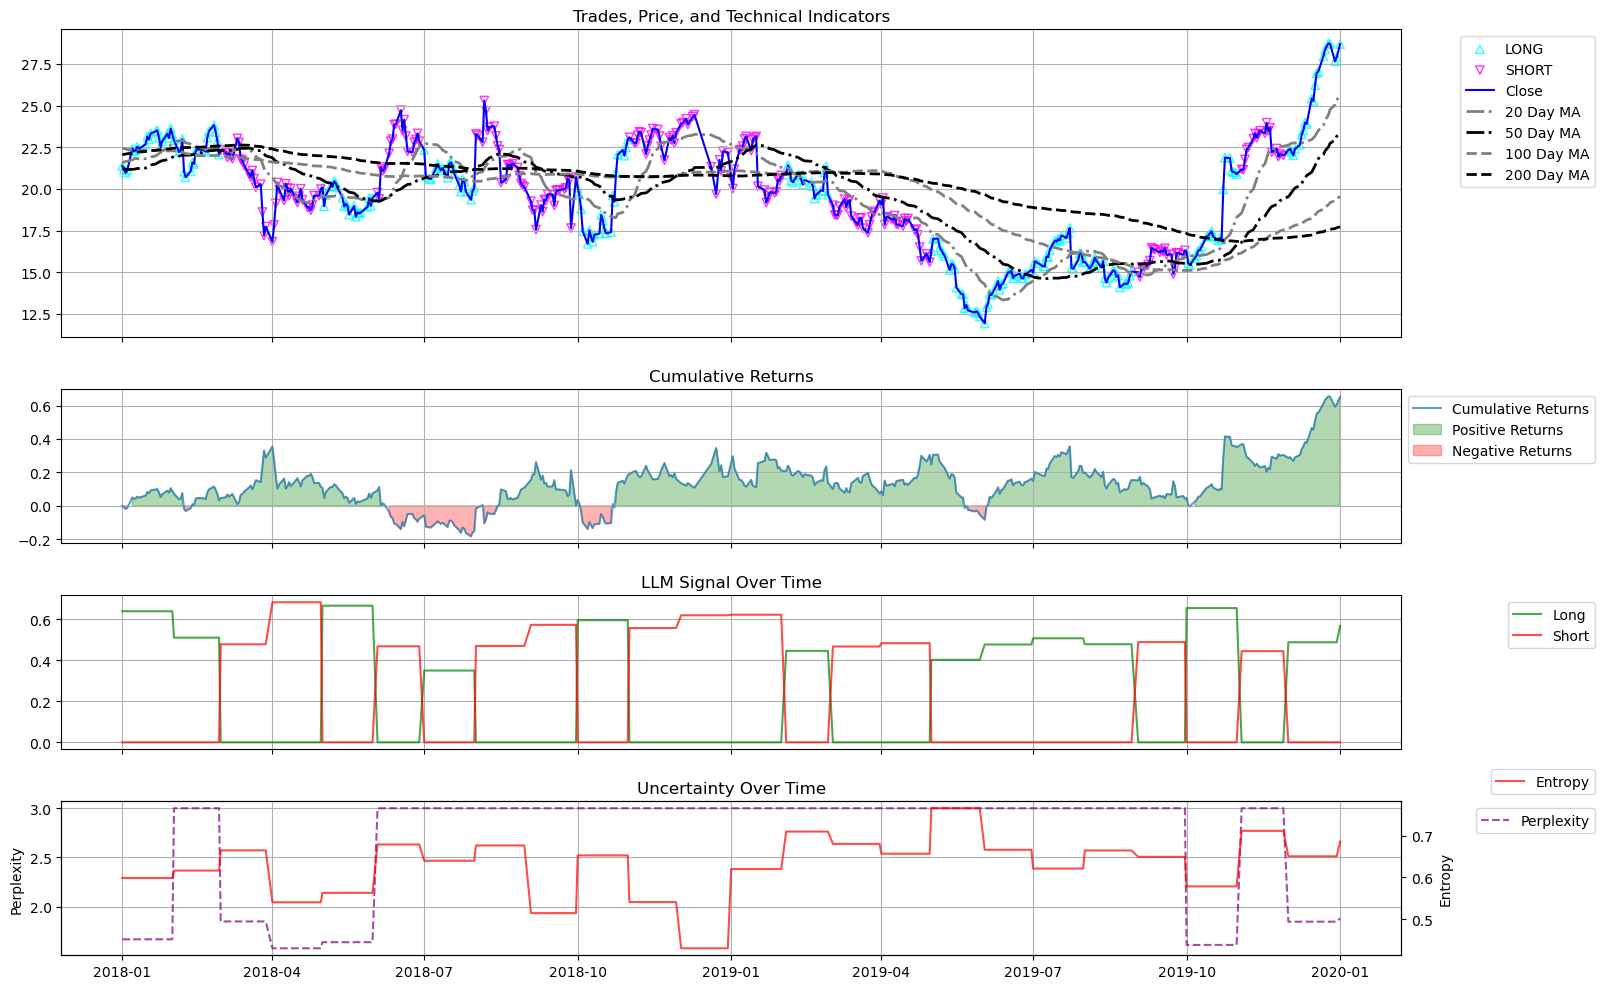

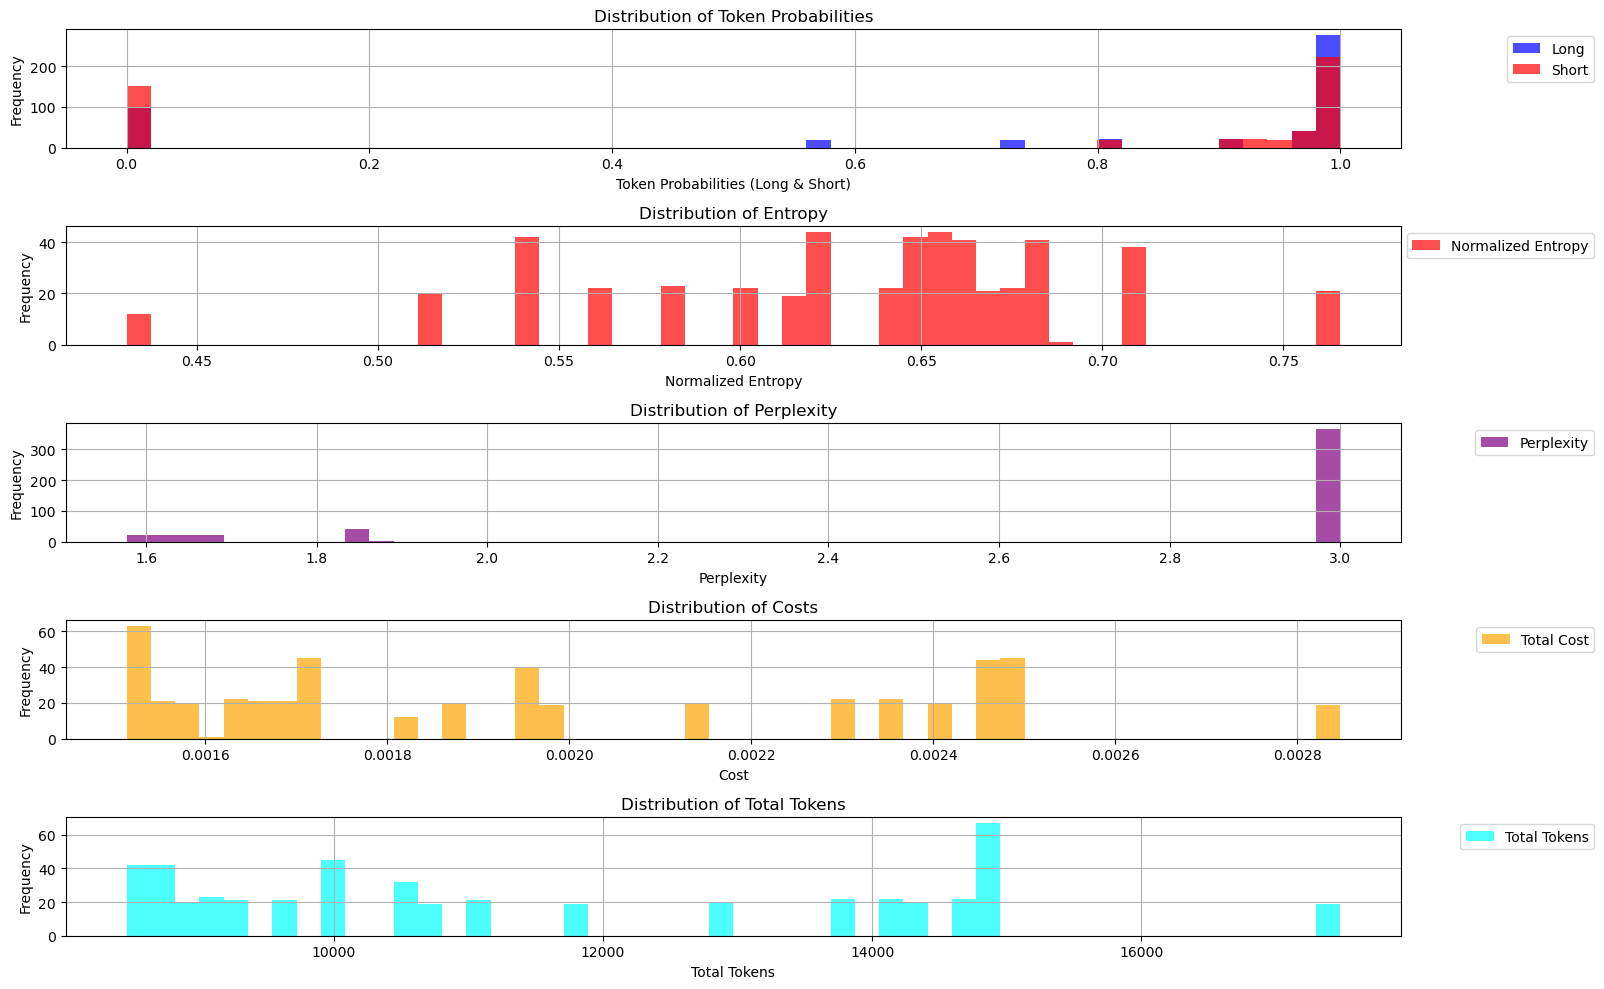

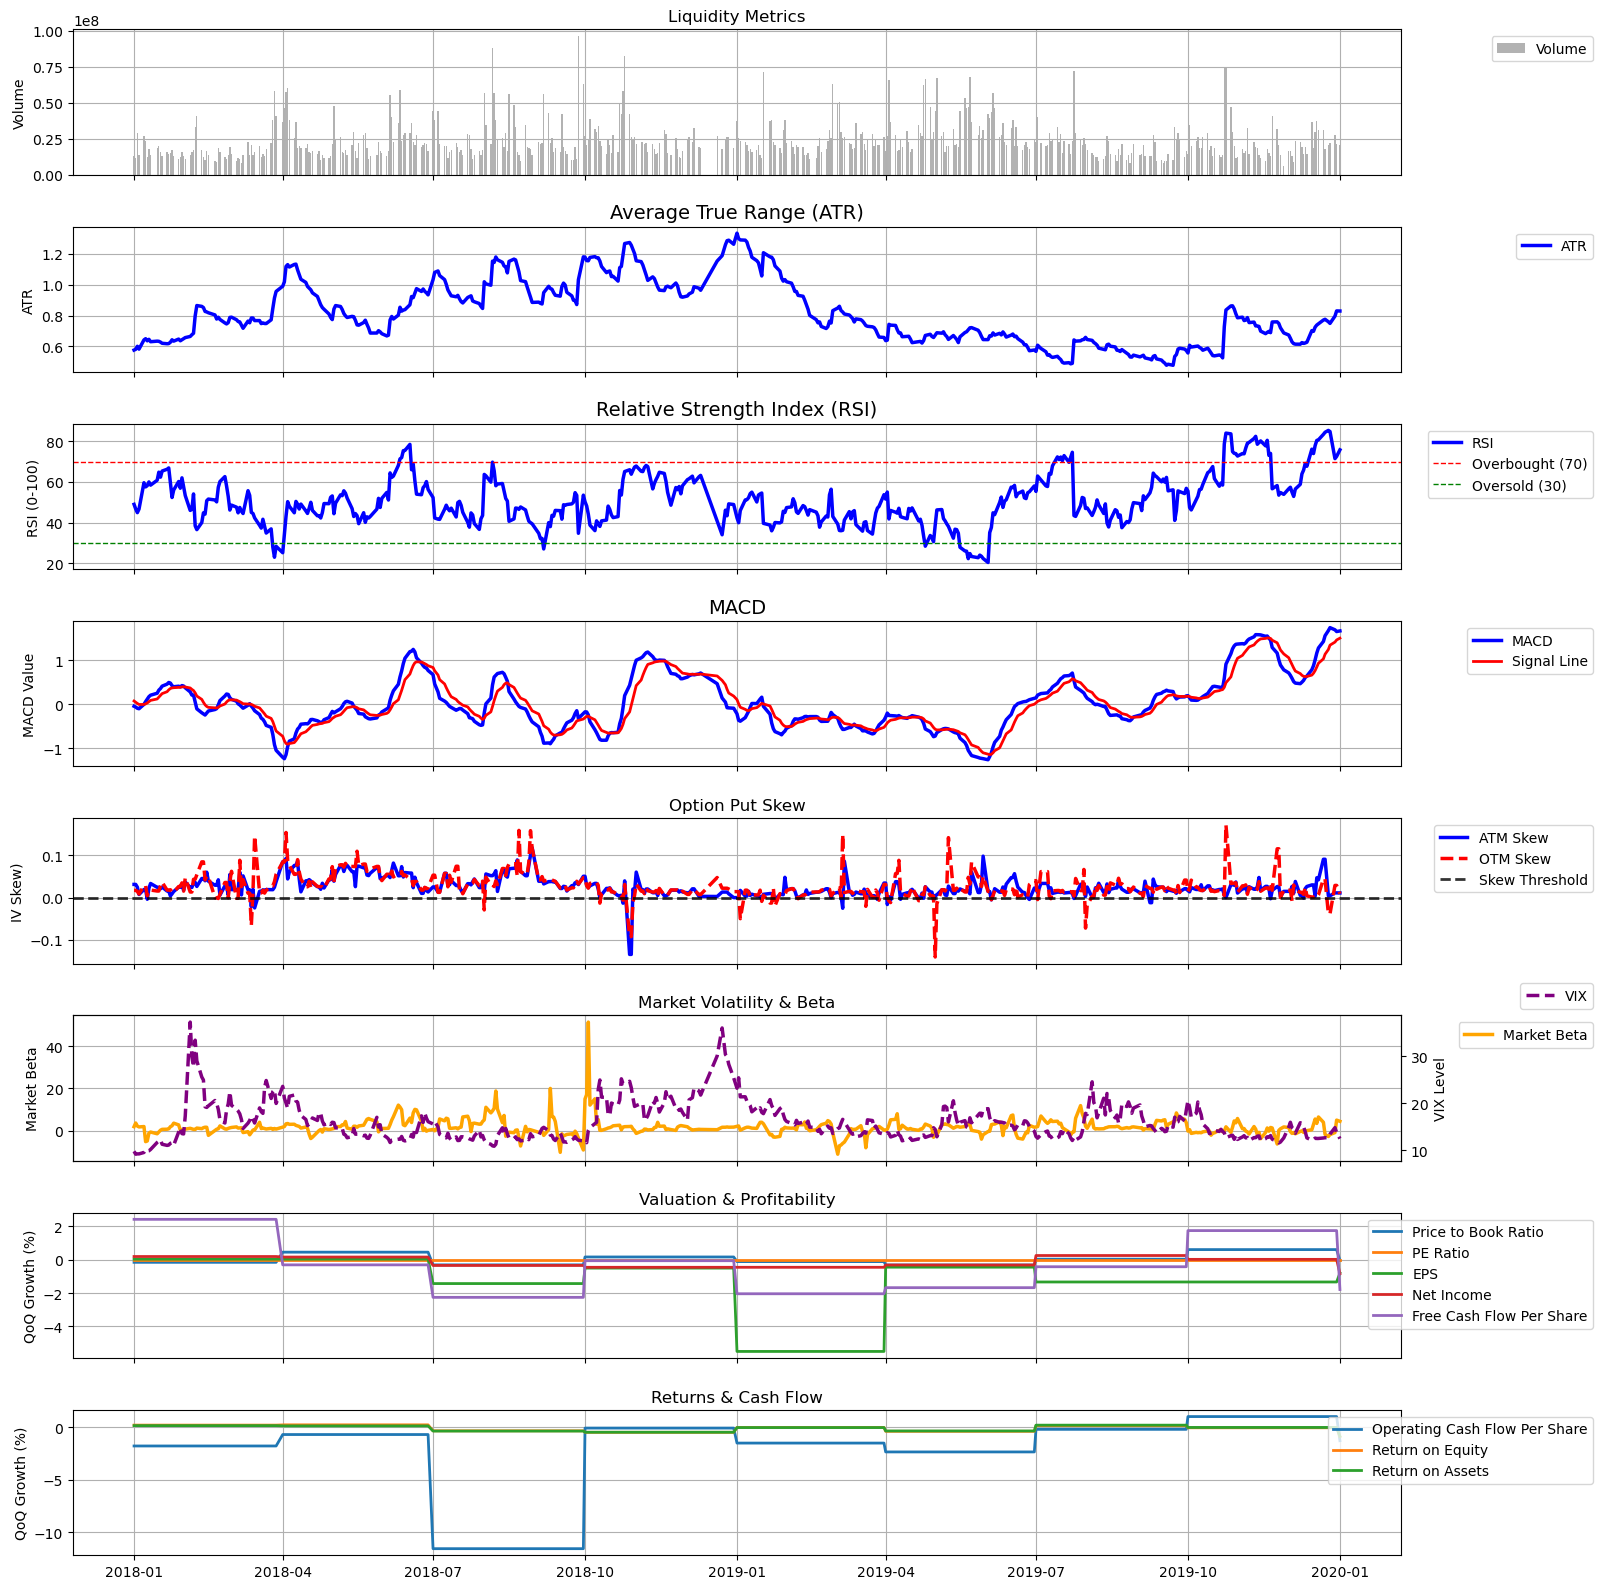

{'Sharpe Ratio (Annualized SR)': 0.7370541509548248,
 'Portfolio Turnover (PTR)': 28.0,
 'Maximum Drawdown (MDD)': 0.39678845217268155,
 'Mean Drawdown Duration (MDDur)': 116.60805084745763,
 'Cumulative Returns': 0.6523387196045345,
 'Mean Perplexity': 2.6563138500713035,
 'Mean Entropy': 0.6319039013377347,
 'Max Perplexity': 3.0,
 'Max Entropy': 0.7657349000613418,
 'Mean Normalized Entropy': None,
 'Max Normalized Entropy': None,
 'Mean Tokens': 11597.416498993964,
 'Mean Costs': 0.001985699094567404,
 'Max Tokens': 17477.0,
 'Max Costs': 0.0028474499999999996,
 'Total Tokens': 5763916.0,
 'Total Costs': 0.9868924499999998}

In [13]:
TARGET = 'TSLA'
output_path='./spottest'
os.makedirs(output_path, exist_ok=True)
engineered_df = load_stock_data(TARGET)
llm_trading_metrics, llm_trades_df = run_llm_trade_experiment(ticker_df = engineered_df,
                                                                output_path=LLM_OUTPUT_PATH,
                                                                ticker = TARGET,
                                                                prompt_version = 'v4',
                                                                news_yaml_file="analyst_prompt_v1.yml",
                                                                start_date=STARTDATE,
                                                                end_date=ENDDATE,
                                                                risk_version = 'r',
                                                                model=OPENAI_MODEL
                                                            )
llm_trading_metrics

In [14]:
TICKERS = ["AAPL", "MSFT", "GOOGL", "TSLA", "AMZN", "META"]

# Prompt V1

In [ ]:
for risk in ['r', 'nr']:
    for ticker in tqdm(TICKERS):
        engineered_df = load_stock_data(ticker)
        llm_trading_metrics, llm_trades_df = run_llm_trade_experiment(ticker_df = engineered_df,
                                                                        ticker = ticker,
                                                                        prompt_version = 'v1',
                                                                        risk_version = risk,
                                                                        plot=False)


# Prompt V2

In [ ]:
for risk in ['r', 'nr']:
    for ticker in tqdm(TICKERS):
        engineered_df = load_stock_data(ticker)
        llm_trading_metrics, llm_trades_df = run_llm_trade_experiment(ticker_df = engineered_df,
                                                                        ticker = ticker,
                                                                        prompt_version = 'v2',
                                                                        risk_version = risk,
                                                                        plot=False)


# Prompt V3

In [ ]:
for risk in ['r', 'nr']:
    for ticker in tqdm(TICKERS):
        engineered_df = load_stock_data(ticker)
        llm_trading_metrics, llm_trades_df = run_llm_trade_experiment(ticker_df = engineered_df,
                                                                        ticker = ticker,
                                                                        prompt_version = 'v3',
                                                                        risk_version = risk,
                                                                        plot=False)


# Prompt V4

In [ ]:
for risk in ['r', 'nr']:
    for ticker in tqdm(TICKERS):
        engineered_df = load_stock_data(ticker)
        llm_trading_metrics, llm_trades_df = run_llm_trade_experiment(ticker_df = engineered_df,
                                                                        ticker = ticker,
                                                                        prompt_version = 'v4',
                                                                        news_yaml_file="analyst_prompt_v1.yml",
                                                                        risk_version = risk,
                                                                        plot=False)

# All Results

In [ ]:
risk_profiles = ["r", "nr"]
prompt_versions = ["v1", "v2", "v3", "v4"]
data = []

for risk_profile in risk_profiles:
    for version in prompt_versions:
        for ticker in TICKERS:
            folder_path = os.path.join(LLM_OUTPUT_PATH, "results", risk_profile, version, ticker)
            json_file_path = os.path.join(folder_path, "llm_results.json")

            # Check if the JSON file exists
            if os.path.exists(json_file_path):
                # Load JSON data
                with open(json_file_path, 'r') as file:
                    results = json.load(file)
                    results['Risk Profile'] = "High Risk" if risk_profile == "r" else "Low Risk"
                    results['Prompt Version'] = version
                    results['Ticker'] = ticker
                    data.append(results)

results_df = pd.DataFrame(data)
results_df.tail(1)


In [ ]:
from pprint import pprint


pivot_table = (
    results_df[results_df["Risk Profile"] == "High Risk"]
    .pivot_table(
        values=["Sharpe Ratio (Annualized SR)", "Mean Perplexity", "Mean Entropy", "Maximum Drawdown (MDD)"],
        index="Ticker",
        columns="Prompt Version",
        aggfunc="mean"
    )
)

pivot_table = pivot_table.sort_index(axis=1, level=1)
pprint(pivot_table)

In [ ]:
summary = (
    results_df[results_df["Risk Profile"] == "High Risk"]
    .groupby("Prompt Version")[["Sharpe Ratio (Annualized SR)", "Mean Perplexity", "Mean Entropy", "Maximum Drawdown (MDD)"]]
    .mean()
    .sort_index()
)

print(summary)


In [ ]:
pivot_table = (
    results_df[results_df["Risk Profile"] == "Low Risk"]
    .pivot_table(
        values=["Sharpe Ratio (Annualized SR)", "Mean Perplexity", "Mean Entropy"],
        index="Ticker",
        columns="Prompt Version",
        aggfunc="mean"
    )
)

pivot_table = pivot_table.sort_index(axis=1, level=1)
pprint(pivot_table)

In [ ]:
summary = (
    results_df[results_df["Risk Profile"] == "Low Risk"]
    .groupby("Prompt Version")[["Sharpe Ratio (Annualized SR)", "Mean Perplexity", "Mean Entropy"]]
    .mean()
    .sort_index()
)

print(summary)
